### Get the Data
Run the following cell to download the CIFAR-10 dataset for python
`(https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz)`.
### Data
CIFAR-10 is an established computer-vision dataset used for object recognition. It is a subset of the
80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10
object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and
Geoffrey Hinton.

In [2]:
# Import necessay library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

In [6]:
import pickle

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

In [5]:

cifar10_dataset_folder_path = 'cifar-10-batches-py'
class DLProgress(tqdm):
    #download progress
    last_block = 0
    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num
if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        
        urlretrieve('https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                    'cifar-10-python.tar.gz',pbar.hook)
if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

In [9]:
# names of the labels as mentioned in file and sites.
def load_label_names():
    # load the names from the files
    return ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [10]:
from sklearn.preprocessing import LabelBinarizer

In [20]:
# load the batch of the dataset. The dataset is broken into batches to prevent running of memory.
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Load a batch of the dataset
    
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
              # Here encoding data type is latin1
              batch = pickle.load(file, encoding='latin1')
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0,2,3,1)
    labels = batch['labels']
    return features, labels


In [38]:

def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    
    """
     Display Stats of the the dataset
    """
    batch_ids = list(range(1, 6))   # we've batch number from 0 to 5
    
    if batch_id not in batch_ids:
        print('Batch Id out of Range. Possible Batch Ids: {}'.format(batch_ids))
        return None
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}. {} is out of range.'.format(len(features),batch_id,
                                                                   sample_id))
        return None
    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 Labels: {}'.format(labels[:20]))
    # to make look look in print let do this
    label_names=load_label_names()
    label_counts=dict(zip(*np.unique(labels,return_counts=True)))
    for key, value in label_counts.items():
        print("Label Counts: [{}][ Label{}]  := {}". format(key,label_names[key].upper(),value))
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    label_names = load_label_names()
    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)

You'll preprocess the images, then train a convolutional neural network on all the samples.
The images need to be normalized and the labels need to be one-hot encoded. You'll get to apply
what you learned and build a convolutional, max pooling, dropout, and fully connected layers.

In [32]:
# Normalize the image data
def normalize(x):
    # x is the input image array [rows,columns,RGB]
    min_val=np.min(x)
    max_val=np.max(x)
    x=(x - min_val)/(max_val - min_val)
    return x

In [33]:
# labels also need to be one hot encoded
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
label_binarizer=preprocessing.LabelBinarizer()
label_binarizer.fit(range(10))

def one_hot_encode(x):
    # x is the lists of labels which is encoded matrix to (no.of labels,no.of class)
    return label_binarizer.transform(x)

In [34]:
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    
    """
     Preprocess data and save it to file
    """
    features = normalize(features)
    labels = one_hot_encode(labels)
    pickle.dump((features, labels), open(filename, 'wb'))

In [54]:
def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    """
       Preprocess Training and Validation Data
    """
    n_batches = 5
    valid_features = []
    valid_labels = []
    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        validation_count = int(len(features) * 0.1)   # 10% batch of whole dataset
# Prprocess and save a batch of training data
        _preprocess_and_save(normalize,one_hot_encode,features[:-validation_count],
                     labels[:-validation_count],'preprocess_batch_' + str(batch_i) + '.p')
         # here normalizing,onehotencoding,saving in new file named "preprocess_batch" +
                                                                  #    " batch number"
# Use a portion of training batch for validation
        valid_features.extend(features[-validation_count:])
        valid_labels.extend(labels[-validation_count:])
# Preprocess and Save all validation data
    _preprocess_and_save(normalize,
                         one_hot_encode,
                         np.array(valid_features),
                         np.array(valid_labels),
                         'preprocess_validation.p')
    # loading the test dataset
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        
        batch = pickle.load(file, encoding='latin1')
# preprocess
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0,2,3,1)
    test_labels = batch['labels']
# Preprocess and Save all testing data
    _preprocess_and_save(normalize,
                         one_hot_encode,
                         np.array(test_features),
                         np.array(test_labels),
                         'preprocess_training.p')

In [59]:
preprocess_and_save_data(cifar10_dataset_folder_path,normalize,one_hot_encode)

In [35]:
def batch_features_labels(features, labels, batch_size):
    """
     Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

In [36]:
def load_preprocess_training_batch(batch_id, batch_size):
    """
     Load the Preprocessed Training data and return them in batches of <batch_size
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))
# Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

In [51]:
def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))
    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)
    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions
    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features,
                                                                                 label_ids,
                                                                                 predictions.indices,
                                                                                 predictions.values)):
        
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]
        axies[image_i][0].imshow(feature*255)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()
        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])


Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]
Label Counts: [0][ LabelAIRPLANE]  := 994
Label Counts: [1][ LabelAUTOMOBILE]  := 1042
Label Counts: [2][ LabelBIRD]  := 965
Label Counts: [3][ LabelCAT]  := 997
Label Counts: [4][ LabelDEER]  := 990
Label Counts: [5][ LabelDOG]  := 1029
Label Counts: [6][ LabelFROG]  := 978
Label Counts: [7][ LabelHORSE]  := 1015
Label Counts: [8][ LabelSHIP]  := 961
Label Counts: [9][ LabelTRUCK]  := 1029

Example of Image 5:
Image - Min Value: 9 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 2 Name: bird


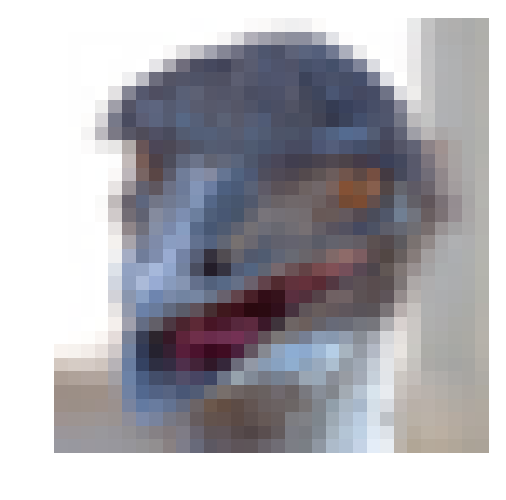

In [39]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
# Explore the dataset
batch_id = 3
sample_id = 5
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)


Stats of batch 5:
Samples: 10000
Label Counts: {0: 1014, 1: 1014, 2: 952, 3: 1016, 4: 997, 5: 1025, 6: 980, 7: 977, 8: 1003, 9: 1022}
First 20 Labels: [1, 8, 5, 1, 5, 7, 4, 3, 8, 2, 7, 2, 0, 1, 5, 9, 6, 2, 0, 8]
Label Counts: [0][ LabelAIRPLANE]  := 1014
Label Counts: [1][ LabelAUTOMOBILE]  := 1014
Label Counts: [2][ LabelBIRD]  := 952
Label Counts: [3][ LabelCAT]  := 1016
Label Counts: [4][ LabelDEER]  := 997
Label Counts: [5][ LabelDOG]  := 1025
Label Counts: [6][ LabelFROG]  := 980
Label Counts: [7][ LabelHORSE]  := 977
Label Counts: [8][ LabelSHIP]  := 1003
Label Counts: [9][ LabelTRUCK]  := 1022

Example of Image 5:
Image - Min Value: 1 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 7 Name: horse


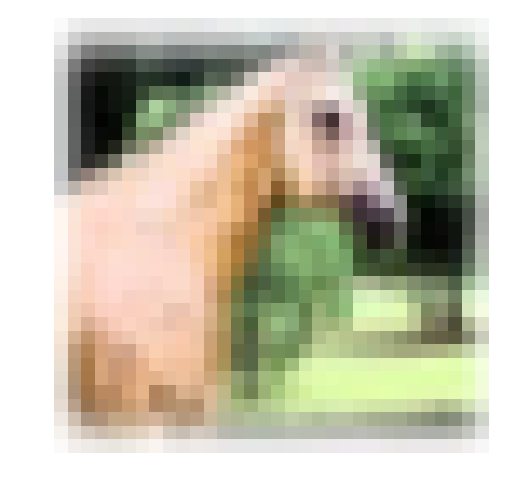

In [40]:
# Explore the dataset
batch_id = 5
sample_id = 5
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

#### checkpoint

In [60]:
valid_features,valid_labels= pickle.load(open('preprocess_validataion.p',mode='rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'preprocess_validataion.p'

In [61]:
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [62]:
# First reset the graph
tf.reset_default_graph()

In [63]:
# tf Graph input
x = tf.placeholder(tf.float32,shape= (None, 32,32,3),name='inputx') # 32x32 pixel, 3=RGB
y = tf.placeholder(tf.float32,shape=(None,10), name='outputy')
keep_prob = tf.placeholder(tf.float32,name='keep_prob')

In [64]:
# create Convolutional Model
# Note : the entire model consists of 14 layers in total. The technique to layer to build it as:
def conv_net(x, keep_prob):
    conv1_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 64], mean=0, stddev=0.08))
    # convolution with 64 different filters in size 3x3
    conv2_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], mean=0, stddev=0.08))
     # convolution with 128 different filters in size 3x3
    conv3_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 128, 256], mean=0, stddev=0.08))
     # convolution with 256 different filters in size 3x3
    conv4_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 256, 512], mean=0, stddev=0.08))
     # convolution with 512 different filters in size 3x3
    #Signature: tf.truncated_normal(shape, mean=0.0, stddev=1.0, dtype=tf.float32,
                                                                   #seed=None, name=None)

#Outputs random values from a truncated normal distribution.
    # 1, 2
    conv1 = tf.nn.conv2d(x, conv1_filter, strides=[1,1,1,1], padding='SAME')
     # ReLU activation function
    conv1 = tf.nn.relu(conv1)
     # max Pooling by 2
    conv1_pool = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
   # batch normalization
    conv1_bn = tf.layers.batch_normalization(conv1_pool)

    # 3, 4
    conv2 = tf.nn.conv2d(conv1_bn, conv2_filter, strides=[1,1,1,1], padding='SAME')
    # ReLU activation function
    conv2 = tf.nn.relu(conv2)
    # max Pooling by 2
    conv2_pool = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME') 
     
    conv2_bn = tf.layers.batch_normalization(conv2_pool)
  
    # 5, 6
    conv3 = tf.nn.conv2d(conv2_bn, conv3_filter, strides=[1,1,1,1], padding='SAME')
     # ReLU activation function
    conv3 = tf.nn.relu(conv3)
      # max Pooling by 2
    conv3_pool = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME') 
   
    conv3_bn = tf.layers.batch_normalization(conv3_pool)
    
    # 7, 8
    conv4 = tf.nn.conv2d(conv3_bn, conv4_filter, strides=[1,1,1,1], padding='SAME')
     # ReLU activation function
    conv4 = tf.nn.relu(conv4)
     # max Pooling by 2
    conv4_pool = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    conv4_bn = tf.layers.batch_normalization(conv4_pool) # batch normalization
    
    # 9
    #Flattening the 3D output of the last convolution operations.
    flat = tf.contrib.layers.flatten(conv4_bn)  

    # 10
    
    full1 = tf.contrib.layers.fully_connected(inputs=flat, num_outputs=128, activation_fn=tf.nn.relu)
    # Fully Connected layer with 128 units
    full1 = tf.nn.dropout(full1, keep_prob)    # dropout
    # Batch Normalization
    full1 = tf.layers.batch_normalization(full1)
    
    # 11
    full2 = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=256, activation_fn=tf.nn.relu)
    # Fully Connected layer with 256 units
    full2 = tf.nn.dropout(full2, keep_prob)  # dropout
    # Batch Normalization
    full2 = tf.layers.batch_normalization(full2)
    
    # 12
    full3 = tf.contrib.layers.fully_connected(inputs=full2, num_outputs=512, activation_fn=tf.nn.relu)
    # Fully Connected layer with 512 units
    full3 = tf.nn.dropout(full3, keep_prob)  # dropout
    # Batch Normalization
    full3 = tf.layers.batch_normalization(full3)    
    
    # 13
    full4 = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=1024, activation_fn=tf.nn.relu)
    # Fully Connected layer with 1024 units
    full4 = tf.nn.dropout(full4, keep_prob) # dropout
    # Batch Normalization
    full4 = tf.layers.batch_normalization(full4)        
    
    # 14
    out = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=10, activation_fn=None)
    return out



### HyperParameters:

In [65]:
epochs = 10   # no. of iteration until the network stops learning or start overfitting
batch_size = 128    # highest no. that machine has memory has.
keep_probability = 0.7  # probability of keeping a node using dropout
learning_rate = 0.001  # it should be very low. Number how fast the model learns


In [66]:
## The cost function and optimizer:
logits = conv_net(x, keep_prob)
model = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
# cost=> return reduce the tensor
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
# optimizer=> an operation that applies the specified gradients.
# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')#return reducedtensor

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



#### Train the Neural Network

In [67]:
# Single Optimization:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer, 
                feed_dict={
                    x: feature_batch,
                    y: label_batch,
                    keep_prob: keep_probability
                })

In [69]:
# showing Stats
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    loss = sess.run(cost, 
                    feed_dict={
                        x: feature_batch,
                        y: label_batch,
                        keep_prob: 1.
                    })
    valid_acc = sess.run(accuracy, 
                         feed_dict={
                             x: valid_features,
                             y: valid_labels,
                             keep_prob: 1.
                         })
    
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))

In [70]:
save_model_path = './image_classification'
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
                
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Epoch  1, CIFAR-10 Batch 1:  Loss:     2.2250 Validation Accuracy: 0.196600
Epoch  1, CIFAR-10 Batch 2:  Loss:     1.8468 Validation Accuracy: 0.250000
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.6397 Validation Accuracy: 0.279200
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.6618 Validation Accuracy: 0.340800
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.4772 Validation Accuracy: 0.392200
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.5134 Validation Accuracy: 0.456000
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.3460 Validation Accuracy: 0.429200
Epoch  2, CIFAR-10 Batch 3:  Loss:     1.1164 Validation Accuracy: 0.507800
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.0843 Validation Accuracy: 0.576400
Epoch  2, CIFAR-10 Batch 5:  Loss:     0.7971 Validation Accuracy: 0.606200
Epoch  3, CIFAR-10 Batch 1:  Loss:     0.9008 Validation Accuracy: 0.612600
Epoch  3, CIFAR-10 Batch 2:  Loss:     0.6410 Validation Accuracy: 0.639800
Epoch  3, CIFAR-10 Batch 3:  Loss:     0.4584 Validation Accuracy: 0.637600
Epoch  3, CI

checkPoint: The model has been saved to disk.